Add image path from google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
shared_folder_path = '/content/drive/My Drive/Data'

In [3]:
import os

for filename in os.listdir(shared_folder_path):
    print(filename)

features_30_sec.csv
features_3_sec.csv
images_original
genres_original
quantized_resnet18.pth
original_model.h5
pruned_model.h5
pruned_model.h5.gz
original_resnet18.pth
saved_data


# Resnet

In [4]:
import torch
import torchvision
# import torchaudio
import random
import numpy as np
import pandas as pd
import os
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from tqdm.autonotebook import tqdm
import IPython.display as ipd
import torchvision.transforms as T

<ipython-input-4-a3a4c313d453>:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
img_path = '/content/drive/My Drive/Data/images_original'

In [6]:
batch_size = 8
image_size = 224

In [7]:
train_trms = T.Compose([
                        T.Resize(image_size),
                        T.RandomRotation(20),
                        T.RandomHorizontalFlip(),
                        T.ToTensor()
                        ])
val_trms = T.Compose([
                        T.Resize(image_size),
                        T.ToTensor()
                        ])

In [8]:
train_data = torchvision.datasets.ImageFolder(root = img_path, transform = train_trms)
val_data = torchvision.datasets.ImageFolder(root = img_path, transform = val_trms)

In [9]:
def Encode(data):
    classes = data.classes
    encoder = {}
    for i in range(len(classes)):
        encoder[i] = classes[i]
    return encoder

def Decoder(data):
    classes = data.classes
    
    decoder = {}
    for i in range(len(classes)):
        decoder[classes[i]] = i
    return decoder

In [10]:
def class_plot(data,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
        label = int(label)
        encoder = Encode(data)
        l = encoder[label]
       
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()

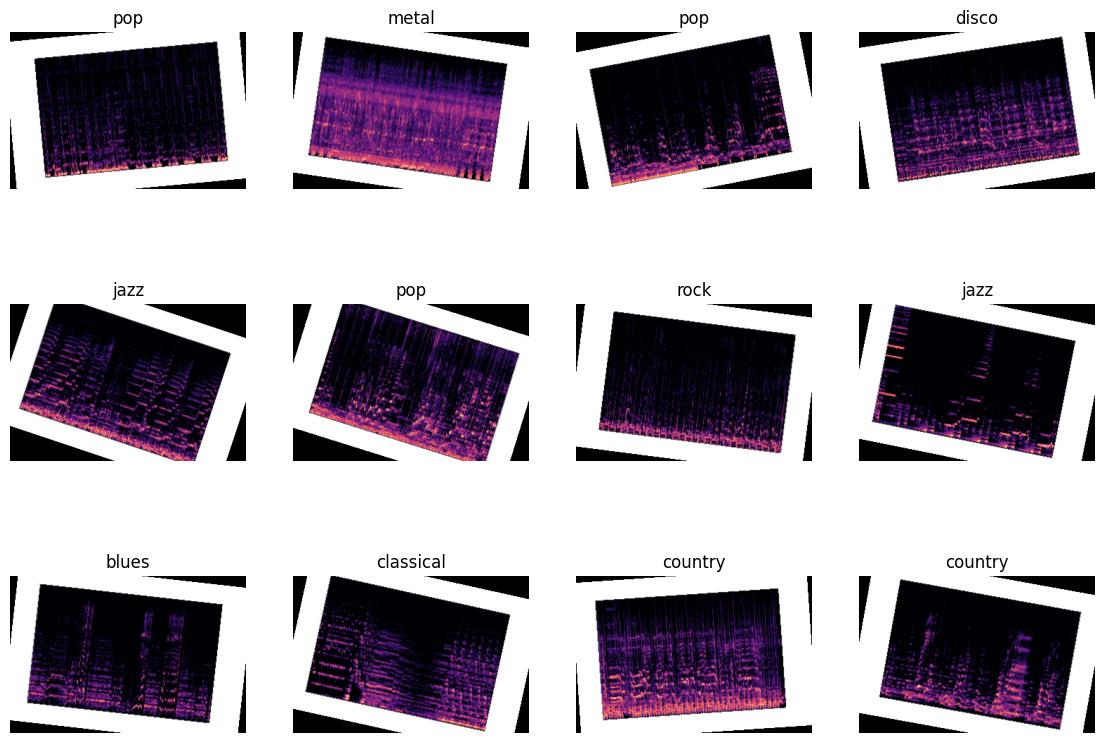

In [11]:
class_plot(train_data)

In [12]:
torch.manual_seed(43)
val_size = int(len(train_data)*0.1)
train_size = len(train_data) - val_size

In [13]:
print('The validation size is ', val_size)
print('The train size is ', train_size)

The validation size is  99
The train size is  900


In [14]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train_data, [train_size,val_size])
len(train_ds), len(val_ds)

(900, 99)

In [15]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [16]:
print(len(train_dl))

113


images.shape: torch.Size([8, 3, 224, 336])


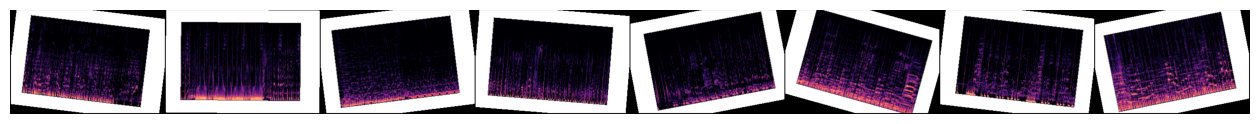

In [17]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [18]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [19]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        score = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['val_loss'], result['val_score']))

In [20]:
import torchvision.models as models
class Net(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return self.network(xb)
    def freeze(self):
      for param in self.network.parameters():
        param.require_grad = False
      for param in self.network.fc.parameters():
        param.require_grad = True
    
    def unfreeze(self):
      for param in self.network.parameters():
        param.require_grad = True

In [21]:
Net()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


Net(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [22]:
def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

@torch.no_grad()
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def train_model(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            loss.backward()
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history









def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
device = get_default_device()
device

device(type='cpu')

In [24]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model = to_device(Net(), device)
torch.cuda.empty_cache()

### Resnet18

In [ ]:
epochs = 5
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
model.freeze()
history = train_model(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)
model.unfreeze()

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [0], val_loss: 2.1525, val_score: 0.2679


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.7871, val_score: 0.3750


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.7076, val_score: 0.4643


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.2806, val_score: 0.6101


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.2475, val_score: 0.5893


In [ ]:
history

[{'val_loss': 2.1525447368621826,
  'val_score': 0.2678571343421936,
  'train_loss': 14.976560786762068,
  'lrs': [3.9999999999999996e-05,
   4.0083425457312504e-05,
   4.033367283005451e-05,
   4.075065513071952e-05,
   4.133422741372801e-05,
   4.2084186825810856e-05,
   4.300027267652271e-05,
   4.408216652885893e-05,
   4.532949230994724e-05,
   4.6741816441772254e-05,
   4.831864799188985e-05,
   5.0059438844078565e-05,
   5.1963583888867734e-05,
   5.4030421233877365e-05,
   5.62592324338968e-05,
   5.864924274061865e-05,
   6.119962137194832e-05,
   6.39094818007871e-05,
   6.677788206319523e-05,
   6.980382508582411e-05,
   7.298625903250555e-05,
   7.632407766987499e-05,
   7.981612075190676e-05,
   8.346117442322126e-05,
   8.725797164102912e-05,
   9.120519261556262e-05,
   9.530146526884299e-05,
   9.954536571162313e-05,
   0.00010393541873833935,
   0.00010847009833990246,
   0.0001131478282341479,
   0.00011796698241376053,
   0.00012292588571148524,
   0.0001280228143824

In [ ]:
epochs = 10
max_lr = 0.000001
grad_clip = 0.3
weight_decay = 5e-3
opt_func = torch.optim.Adam

In [ ]:
# Resnet18
history = train_model(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [0], val_loss: 1.8032, val_score: 0.3750


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.7430, val_score: 0.4405


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.7606, val_score: 0.3929


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.7113, val_score: 0.4048


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.7036, val_score: 0.4583


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5], val_loss: 1.6915, val_score: 0.4315


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [6], val_loss: 1.6616, val_score: 0.4762


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [7], val_loss: 1.6940, val_score: 0.4673


  0%|          | 0/113 [00:00<?, ?it/s]

FileNotFoundError: ignored

In [ ]:
# Resnet18
history += train_model(20, max_lr, model, train_dl, val_dl, 
                        grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [0], val_loss: 2.1276, val_score: 0.2232


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 2.1574, val_score: 0.2143


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 2.1622, val_score: 0.2054


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 2.1344, val_score: 0.2143


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 2.0440, val_score: 0.2946


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5], val_loss: 2.0901, val_score: 0.2321


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [6], val_loss: 2.0001, val_score: 0.3244


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [7], val_loss: 1.9828, val_score: 0.3214


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [8], val_loss: 1.9628, val_score: 0.3125


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [9], val_loss: 1.9469, val_score: 0.3393


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [10], val_loss: 1.9154, val_score: 0.3571


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [11], val_loss: 1.8644, val_score: 0.4137


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [12], val_loss: 1.9382, val_score: 0.3214


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [13], val_loss: 1.8792, val_score: 0.3214


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [14], val_loss: 1.8699, val_score: 0.4048


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [15], val_loss: 1.8330, val_score: 0.4494


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [16], val_loss: 1.8429, val_score: 0.3690


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [17], val_loss: 1.8482, val_score: 0.2946


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [18], val_loss: 1.8455, val_score: 0.3482


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [19], val_loss: 1.8317, val_score: 0.4137


In [ ]:
max_val_score = 0
for i in range(len(history)):
    if max_val_score < history[i]['val_score']:
        max_val_score = history[i]['val_score']

print('max val_score:', max_val_score)

max val_score: 0.6101189851760864


In [27]:
torch.save(model.state_dict(), '/content/drive/My Drive/Data/original_resnet18.pth')

### Model compress

In [25]:
!pip install -U torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.quantization import QuantStub, DeQuantStub


Create a custom quantized ResNet18 model

In [28]:
class QuantizedResNet18(nn.Module):
    def __init__(self, num_classes=1000):
        super(QuantizedResNet18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_classes)
        
        # Add quantization stubs to the ResNet model
        self.resnet18.quant = torch.quantization.QuantStub()
        self.resnet18.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.resnet18.quant(x)
        x = self.resnet18(x)
        x = self.resnet18.dequant(x)
        return x


Update the Net class definition to use the custom QuantizedResNet18 class

In [29]:
class Net(MultilabelImageClassificationBase):
    def __init__(self, pretrained_model=None):
        super().__init__()
        if pretrained_model is None:
            self.network = QuantizedResNet18(num_classes=10)
        else:
            self.network = pretrained_model

    def forward(self, xb):
        return self.network(xb)

    def freeze(self):
        for param in self.network.resnet18.parameters():
            param.requires_grad = False
        for param in self.network.resnet18.fc.parameters():
            param.requires_grad = True

    def unfreeze(self):
        for param in self.network.resnet18.parameters():
            param.requires_grad = True

    # def freeze(self):
    #     for param in self.network.resnet18.parameters():
    #         param.requires_grad = False
    #     for param in self.network.resnet18.fc.parameters():
    #         param.requires_grad = True

    # def unfreeze(self):
    #     for param in self.network.resnet18.parameters():
    #         param.requires_grad = True

    # def training_step(self, batch):
    #     images, labels = batch 
    #     out = self(images)                  # Generate predictions
    #     loss = F.cross_entropy(out, labels) # Calculate loss
    #     return loss

    # def training_acc(self, batch):
    #     images, labels = batch
    #     out = self(images)
    #     acc = accuracy(out, labels)
    #     return acc

    # def validation_step(self, batch):
    #     images, labels = batch 
    #     out = self(images)                    # Generate predictions
    #     loss = F.cross_entropy(out, labels)   # Calculate loss
    #     acc = accuracy(out, labels)           # Calculate accuracy
    #     return {'val_loss': loss.detach(), 'val_acc': acc}
    
    # def validation_epoch_end(self, outputs):
    #     batch_losses = [x['val_loss'] for x in outputs]
    #     epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    #     batch_accs = [x['val_acc'] for x in outputs]
    #     epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    #     return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    # def epoch_end(self, epoch, result):
    #   print(f"Epoch [{epoch}], train_loss: {result['train_loss']:.4f}, train_acc: {result['train_acc']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")

    
    

In [33]:
# Instantiate the model
compressed_model = Net()



# Set the backend 
backend = "fbgemm"  # Update this to match your target device's architecture
torch.backends.quantized.engine = backend

# Specify the data loader for calibration
calibration_loader = train_dl  # Replace with DataLoader




# Prepare the model for quantization
compressed_model.network.qconfig = torch.quantization.get_default_qconfig(backend)
torch.quantization.prepare(compressed_model.network, inplace=True)

# Calibrate the model using a few iterations of data from the calibration_loader
for i, (inputs, _) in enumerate(calibration_loader):
    if i >= 5:  # Use only the first 5 batches for calibration
        break
    compressed_model.network(inputs)

# Convert the model to a quantized model
compressed_model = torch.quantization.convert(compressed_model.network, inplace=True)

/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [34]:
torch.save(compressed_model.state_dict(), '/content/drive/My Drive/Data/quantized_resnet18.pth')

In [37]:
from torch.quantization import quantize_dynamic

# Set the model to evaluation mode
model.eval()

# Perform dynamic quantization
compressed_model = quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)


In [38]:
import time
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate_model(model, data_loader):
    model.eval()
    with torch.no_grad():
        total_samples = 0
        correct_predictions = 0
        total_time = 0
        
        for inputs, labels in data_loader:
            start_time = time.time()
            outputs = model(inputs)
            end_time = time.time()
            
            total_time += (end_time - start_time)
            total_samples += len(inputs)
            correct_predictions += (accuracy(outputs, labels) * len(inputs)).item()
        
        avg_inference_time = total_time / total_samples
        accuracy_score = correct_predictions / total_samples

    return avg_inference_time, accuracy_score

inference_time_original, accuracy_original = evaluate_model(model, val_dl)
inference_time_quantized, accuracy_quantized = evaluate_model(compressed_model, val_dl)


In [39]:
print("Original model:")
print(f"Accuracy: {accuracy_original:.4f}")
print(f"Avg. inference time: {inference_time_original:.8f} seconds")

print("\nQuantized model:")
print(f"Accuracy: {accuracy_quantized:.4f}")
print(f"Avg. inference time: {inference_time_quantized:.8f} seconds")

compression_ratio = os.path.getsize('/content/drive/My Drive/Data/original_resnet18.pth') / os.path.getsize('/content/drive/My Drive/Data/quantized_resnet18.pth')
print(f"\nCompression ratio: {compression_ratio:.2f}")


Original model:
Accuracy: 0.0707
Avg. inference time: 0.12999684 seconds

Quantized model:
Accuracy: 0.0808
Avg. inference time: 0.17026159 seconds

Compression ratio: 3.93
